# PicoCore Battery SOC (*State of Charge*) Equations

This document focuses on the development and testing of **State of Charge (SOC)** estimation and **runtime** equations used by PicoCore.

### Imports
Here are some imports used to generate graphics:

In [19]:
import matplotlib.pyplot as plt
import numpy as np

### Constants

The following constants are known beforehand:


In [20]:
measurement_interval = 1  # s
V_max = 5.4
V_nominal = 5.2
V_min = 3.6  # cut-off
ah = 2.4  # ampere hours
P_inflection = 0.2 # point of inflection of a normalized discharge curve near cutoff voltage

---
### Gathered Data

The following data is gathered during runtime in an interval of `measurement_interval`: 

0.0196046999999977 0.002163300000000312


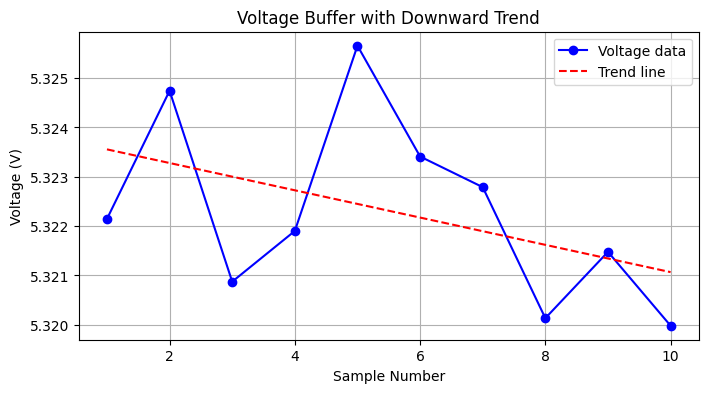

In [29]:
# dataset with a slight downward trend
voltage_buffer = [
    5.3221454,
    5.3247421,
    5.3208745,
    5.3219023,
    5.3256548,
    5.3234102,
    5.3227895,
    5.3201349,
    5.3214786,
    5.3199821,
]
"""
voltage_buffer=[
5.270616,
5.306398,
5.2777724,
5.294471,
5.3040124,
5.308783,
5.3040124,
5.296856,
5.2992416,
5.2777724,
]"""
# Total voltage difference accounting for all changes
total_diff = sum(abs(voltage_buffer[i+1] - voltage_buffer[i]) for i in range(len(voltage_buffer)-1))
print(total_diff,voltage_buffer[0]-voltage_buffer[-1])

# ------------ Plotting ------------

# Sample indices
samples = np.arange(1, len(voltage_buffer) + 1)

# Calculate linear regression (trend line)
coefficients = np.polyfit(samples, voltage_buffer, 1)  # degree 1 for linear
trendline = np.polyval(coefficients, samples)

# Plot the connected data points
plt.figure(figsize=(8, 4))
plt.plot(samples, voltage_buffer, '-o', label='Voltage data', color='blue')

# Plot the trend line separately
plt.plot(samples, trendline, '--', label='Trend line', color='red')

plt.title("Voltage Buffer with Downward Trend")
plt.xlabel("Sample Number")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.legend()
plt.show()


---
### Variables (over time usage)

#### Unit definitions
- $T = measurement\_interval$
- $N = execution\_round = n \times T$

These variables are used over time during runtime to enhance prediction/estimation accuracy.


In [30]:
normalized_voltage_buffer_10T = []  # per 10 time units meaning 10 * T (measurement_interval)
N = 0  # used for controlled append after 10-T to buffer so if N = 10 * T
T = measurement_interval

### Theory: Calculating the Rate of Voltage Change

We begin by defining the instantaneous change in voltage, $dv$, as the difference between consecutive voltage measurements stored in a buffer:

$$dV = \verb|voltage_buffer|[n] - \verb|voltage_buffer|[n+1]$$

The time interval $\Delta{t}$ between these measurements is a constant time step $T$:

$$\Delta{t} = T$$

We can now calculate the **rate of change** of the voltage, $V$ (denoted in physics notation as $\dot{V}$, or "v-dot"):

$$\vec{\dot{V}} \approx \frac{\Delta{V}}{\Delta{t}} = \frac{V[n] - V[n+1]}{T}$$

> Note: we use $\approx$ as we use $\Delta$ instead of d ( approximation dependent on $\verb|T|$) for the first derivative of V to get $\dot{V}$.

---

#### Interpreting $\dot{V}$

The rate of voltage change is a key diagnostic indicator for battery health:

*   **Rapid Voltage Drops (High $|\dot{V}|$):** A healthy battery maintains a relatively stable voltage under normal load. A battery whose voltage drops very quickly (a large negative $\frac{\Delta{V}}{\Delta{t}}$ value) when a load is applied usually indicates **high internal resistance** or **degradation**.

---

#### Estimating Time Remaining (TTE)

Using the measured voltage slope, we can perform a linear extrapolation to estimate how much time remains until the battery reaches its critical **cut-off voltage**.

First, we calculate the average rate of voltage change over a specific observation period:

$$\text{Average Rate } = \dot{V}_{\text{average}} = \frac{\text{Voltage Drop}}{\text{Time Elapsed}}$$

Then, we extrapolate this rate linearly to the cut-off voltage to estimate the remaining time:

$$\text{Linear Time Remaining} = \frac{\text{Current Voltage} - \text{Cut-off Voltage}}{|\dot{V}_{\text{average}}|} = \frac{\text{V[n]} - \verb|V_min|}{|\dot{V}_{\text{average}}|}$$



In [31]:
def calc_v_drop():
    """Calculates the total voltage drop across the buffer (Volts)."""
    return voltage_buffer[0] - voltage_buffer[-1]


def calc_v_dot():
    """Calculates the average rate of voltage change (V/s)."""
    # Use len(buffer) - 1 for the number of intervals
    total_time_elapsed = T * (len(voltage_buffer) - 1)
    return calc_v_drop() / total_time_elapsed


# Calculate the average rate of change
v_dot = calc_v_dot()


def distance_to_cutoff():
    """Calculates the remaining voltage difference until v_min is reached."""
    return voltage_buffer[-1] - V_min


def time_remaining():
    """Calculates the estimated time remaining in seconds (s)"""
    distance = distance_to_cutoff()
    rate = abs(v_dot)  # Use absolute value to ensure positive time
    return distance / rate


# --- Execute and Print Results ---
etco = time_remaining()

print(
    "Time Remaining till empty: ",
    f"{etco:.2f}s",
    f"{etco/60:.2f}min",
    f"{etco/(60*60):.2f}h",
)

Time Remaining till empty:  7155.66s 119.26min 1.99h



#### Limitation: Non-Linear Discharge Curves

**The simple linear estimation above only works reliably when the battery voltage is within its nominal, relatively flat operating range.**

Battery discharge curves are typically S-shaped (sigmoidal). The slope ($\dot{V}$) is nearly flat in the middle (nominal range) and becomes very steep at both the start (full charge) and the end of life (near cut-off).

Therefore, we must adjust our methodology:

1.  **Estimate Time to "End of Nominal Range":** Determine the time until the voltage measurement leaves the flat, predictable zone.
2.  **Estimate the Curve Part:** When the voltage drops significantly and $\dot{V}_{\text{average}}$ rapidly increases (becomes a larger negative number), the linear extrapolation will fail and significantly underestimate the time remaining. More sophisticated modeling (e.g., a lookup table or a Kalman filter) is required to accurately estimate the remaining time within that final steep curve.


Meaning we nead to introduce a limiting factor to replace cutoff voltage in the current equation:


- $P_{inflection}$ Defines the fractional increase above the cutoff voltage that marks the end of the nominal discharge range.It represents how much higher the voltage is at the transition point compared to the cutoff voltage (e.g., 10 % → 0.10).

    - as extracted in (Battery-SOC-Curve)[./Battery-SOC-Curve.ipynb] $P_{inflection} = 0.2$

- $V_{end}$ Defines the End of Nominal Range Voltage, i.e. the upper boundary of the final, non-linear discharge region of the battery.Beyond this point, the voltage begins to drop rapidly toward $V_{cutoff}$.

The relationship between both parameters is given by:

$$
V_{end} = V_{cutoff} \times (1+ P_{inflection})
$$

So now the time till end of nominal voltage ( part where the curve is approximately linear ) can be calculated using:



$$
\text{Linear Time Remaining} = \frac{\text{V[n]} - V_{end}}{|\vec{\dot{V}}_{\text{average}}|}
$$

In [32]:
#calculating v_end
V_end = V_min * (1 + P_inflection)

def calc_distance_to_Vend():
    """Calculates the remaining voltage difference until V_end is reached."""
    return voltage_buffer[-1] - V_end

def calc_time_remaining_nominal():
    """Calculates the estimated time remaining in seconds (s) till End of Nominal range."""
    distance = calc_distance_to_Vend()
    rate = abs(v_dot)  # Use absolute value to ensure positive time
    return distance / rate

# --- Execute and Print Results ---
etco = calc_time_remaining_nominal()

print(
    "Time Remaining till End of Nominal Range: ",
    f"{etco:.2f}s",
    f"{etco/60:.2f}min",
    f"{etco/(60*60):.2f}h",
)

Time Remaining till End of Nominal Range:  4160.24s 69.34min 1.16h


### Correction: Preprocessing and extracting data
This cell addresses the previously flawed data extraction from `voltage_buffer`.

Previously the **Voltage Drop** was calculated using:

$$
Voltage Drop = \verb|voltage_buffer|[n=0] - \verb|voltage_buffer|[n-1]
$$

However, this approach ignores all other data points and assumes a linear, consistent measurement. Since power draw is not always constant and the battery load affects measurable voltage—as can be seen in the data—all points need to be included.
- **Condition**: Preprocessed data (filtering applied, sensor drift compensated, etc.)

So now we calculate the actual **Total Voltage Drop**:


$$
\text{Total Voltage Drop} = \sum_{i=0}^{n-1} \left| V_{i+1} - V_i \right|
$$


In [33]:
total_diff = sum(abs(voltage_buffer[i+1] - voltage_buffer[i]) for i in range(len(voltage_buffer)-1))

def calc_v_dot():
    """Calculates the average rate of voltage change (V/s)."""
    # Use len(buffer) - 1 for the number of intervals
    total_time_elapsed = T * (len(voltage_buffer) - 1)
    return total_diff / total_time_elapsed

v_dot = calc_v_dot()

etco = calc_time_remaining_nominal()

print(
    "Time Remaining till End of Nominal Range: ",
    f"{etco:.2f}s",
    f"{etco/60:.2f}min",
    f"{etco/(60*60):.2f}h",
)

Time Remaining till End of Nominal Range:  459.07s 7.65min 0.13h
